<a href="https://colab.research.google.com/github/williamgomalley/ML_Finance_Codes/blob/master/SmallerDataSetOLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
#@title Default title text
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import timeit
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta

%matplotlib inline 

### Define a deep neural network (with $L-1$ hidden layers) model in Keras

We define functions for the creation, training, and optional parameter tuning of the model. 

In [107]:
def NN(n_inputs, n_units=50, dropout=0.1, l1_reg=0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0, L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

In [108]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

This function selects the best-performing combination of parameter values in `param_grid` cross-validated over `cv` folds

In [109]:
def parameter_tuning(X, y, cv=3, n_epochs=100, n_batch=10, seed=7):
    param_grid = dict(n_inputs=[X.shape[1]], n_units=[10, 20, 50], 
                      l1_reg = [0, 0.0001, 0.001], activation=['relu','tanh']) 
    estimator = KerasRegressor(build_fn=NN, epochs=n_epochs, batch_size=n_batch, verbose=0)   
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv)
    grid_result = grid.fit(X, y, callbacks=[es])
  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result.best_params_

In [110]:
def training(X, Y, training_dates, L, tune=False):
 
    n_epochs = 100 # maximum number of epochs (to be used with early stopping)
    n_batch = 10 # mini-batch size
    drop_out = 0.0 # level of dropout (set between 0 and 1)
    n_units = 10   
    l1_reg = 0.001 # L_1 regularization parameter
    activation = 'tanh'

    # Create the dictionaries to hold the results
    models = {}
    models['linear'] = []
    models['NN'] = []

    xs = {}
    xs['train'] = []
    xs['test'] = []
    
    ys = {}
    ys['train'] = []
    ys['test'] = []
    
    betas = {}
    betas['NN'] = []
    betas['linear'] = []

    i = 0
    for date in training_dates:
        start_time = timeit.default_timer()  
        print(i, date)
        
        # The following month's date (for the test set)
        date_next = pd.Timestamp(np.datetime64(date)).to_pydatetime() + relativedelta(months=+1)
        date_next = date_next.strftime('%Y-%m-%d')

        # Get the indices of the training and testing points
        train_index = X[X['date'] == date].index
        test_index  = X[X['date'] == date_next].index
        
        # Skip the model if either the train or test sets would be empty
        if len(train_index) == 0 or len(test_index) == 0:
            continue

        # Make the train and test sets
        x_train = X.loc[train_index]
        x_train = x_train.drop("date", axis=1)
        y_train = Y.loc[train_index]
        y_train= y_train.drop("date", axis=1)
        x_test = X.loc[test_index]
        x_test = x_test.drop("date", axis=1)
        y_test = Y.loc[test_index]
        y_test = y_test.drop("date", axis=1)
        
        n_inputs = x_train.shape[1]
        if n_inputs == 0:
            continue
       
        if tune: # Only perform parameter tuning once
            print("Parameter tuning with X-validation...")
            best_params = parameter_tuning(x_train, y_train, 3)
            n_units = best_params['n_units']
            l1_reg = best_params['l1_reg']
            activation = best_params['activation']
            tune = False
        
        # Create and fit the NN for the current training date
        model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
        model.fit(x_train.values, y_train.values, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es])   
        beta = sensitivities(model, x_train.values, L, activation)   
        
        # Save the results
        models['NN'].append(model)
        betas['NN'].append(beta)
        
        # Fit the OLS regression model for the current date
        x = sm.add_constant(x_train)
        model = sm.OLS(y_train, x).fit()
        
        # Save the results
        betas['linear'].append(model.params)
        models['linear'].append(model)
        
        # Save the corresponding inputs and outputs for each model 
        xs['train'].append(x_train)
        xs['test'].append(x_test)
        ys['train'].append(y_train)
        ys['test'].append(y_test)

        elapsed = timeit.default_timer() - start_time
        print("Elapsed time: " + str(elapsed) + " (s)")
        i += 1
        
    return models, betas, xs, ys

This function allows us to compute the feature sensitivities in the deep network. It assumes that the activation function is either $tanh$ or $relu$.

In [111]:
def sensitivities(lm, X, L, activation='tanh'):
    W = lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta = np.zeros((M, p+1))
    B_0 = W[1]
    for i in range (0, L):
        if activation == 'tanh':  
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.tanh(B_0)) + W[2*(i+1)+1])
        elif activation == 'relu':
            B_0 = (np.dot(np.transpose(W[2*(i+1)]), np.maximum(B_0, 0)) + W[2*(i+1)+1])
    beta[:, 0] = B_0 # intercept \beta_0 = F_{W,b}(0)
    for i in range(M):
        I1 = np.dot(np.transpose(W[0]), np.transpose(X[i,])) + W[1]
        if activation == 'tanh':
            Z = np.tanh(I1)  
            D = np.diag(1 - Z**2)
        elif activation == 'relu':
            Z = np.maximum(I1, 0)
            D = np.diag(np.sign(Z)) 
        
        for j in range(p):
            J = np.dot(D, W[0][j])       
            for a in range (1, L):
                I = np.dot(np.transpose(W[2*a]), Z) + W[2*a+1] 
                if activation == 'tanh':  
                    Z = np.tanh(I)
                    D = np.diag(1 - Z**2)
                elif activation == 'relu':    
                    Z = np.maximum(I,0)
                    D = np.diag(np.sign(Z)) 
                J = np.dot(np.dot(D, np.transpose(W[2*a])), J)
            beta[i, j+1]=np.dot(np.transpose(W[2*L]), J)
    return beta

Load the data

In [112]:
X = pd.read_csv('X_small.csv') # Factor exposures
Y = pd.read_csv('Y_small.csv') # Asset returns

## Training of models 
A new cross-sectional neural network model is fitted in each period. To evaluate the performance of strategies, we need to train a model for each time step over a historical period. 

In [113]:
training_periods = 100
L = 2 # Number of hidden and output layers
dates = np.unique(X['date'])[0:training_periods] 
models, betas, xs, ys = training(X, Y, dates, L, False) # Set last argument to True to perform cross-validation for parameter tuning

0 2008-02-01
Epoch 00017: early stopping
Elapsed time: 1.2848627470011706 (s)
1 2008-03-01
Epoch 00017: early stopping
Elapsed time: 1.0574078829995415 (s)
2 2008-04-01
Epoch 00013: early stopping
Elapsed time: 0.9449876619983115 (s)
3 2008-05-01
Epoch 00012: early stopping
Elapsed time: 0.886064237998653 (s)
4 2008-06-01
Epoch 00014: early stopping
Elapsed time: 0.9307286299990665 (s)
5 2008-07-01
Epoch 00011: early stopping
Elapsed time: 0.8162450059971889 (s)
6 2008-08-01
Epoch 00014: early stopping
Elapsed time: 0.8869698859998607 (s)
7 2008-09-01
Epoch 00013: early stopping
Elapsed time: 0.8697395919989503 (s)
8 2008-10-01
Epoch 00052: early stopping
Elapsed time: 1.6039435170023353 (s)
9 2008-11-01
Epoch 00018: early stopping
Elapsed time: 0.9837853669996548 (s)
10 2008-12-01
Epoch 00026: early stopping
Elapsed time: 1.143769392001559 (s)
11 2009-01-01
Epoch 00028: early stopping
Elapsed time: 1.1570059359983134 (s)
12 2009-02-01
Epoch 00017: early stopping
Elapsed time: 0.953913

In [114]:
n_var = np.shape(betas['NN'][1])[1] - 1

betamu = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
sd = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)
mu_ols = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods, n_var)

for i in range(training_periods):
    betamu[i, :] = np.median(betas['NN'][i], axis=0)[1:]
    sd[i, :] = np.std(betas['NN'][i], axis=0) [1:]
    mu_ols[i, :] = betas['linear'][i][1:]

In [119]:
S=len(ys['train'][0])

In [120]:
#NN Variance MSE
NNMSE=0
MSE_array_NN_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    var_hat_NN_is.append(np.var(models['NN'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NNvar=np.matmul(np.matmul((NNbeta[i][k]), Omegaf), np.transpose(NNbeta[i][k]))
        test[i][k]=NNvar

    MSE_test_NN = np.square((test[i])-np.var(ys['train'][i].values)).mean()
    MSE_array_NN_var_in[i] = MSE_test_NN
    NNMSE += MSE_test_NN
print("NN_MSE: " + str(NNMSE / training_periods))
NN_MSE_var=NNMSE / training_periods

NN_MSE: 0.01948376776145175


In [121]:
#NN Variance Inf Norm
inf_norm=0
inf_norm_array_NN_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    var_hat_NN_is.append(np.var(models['NN'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NNvar=np.matmul(np.matmul((NNbeta[i][k]), Omegaf), np.transpose(NNbeta[i][k]))
        test[i][k]=NNvar

    #print((test[i]))
    inf_norm_test_NN = np.max(np.abs((test[i])-np.var(ys['train'][i].values)))
    inf_norm_array_NN_var_in[i] = inf_norm_test_NN
    inf_norm += inf_norm_test_NN
print("inf_norm: " + str(inf_norm / training_periods))
NN_var_inf_norm=inf_norm / training_periods

inf_norm: 0.036980783304153275


In [122]:
#OLS Variance MSE
OLSMSE=0
MSE_array_OLS_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    var_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLSvar=np.matmul(np.matmul((OLSbeta[i]), Omegaf), np.transpose(OLSbeta[i]))
    test[i]=OLSvar

    #print((test[i]))
    MSE_test_OLS = np.square((test[i])-np.var(ys['train'][i].values)).mean()
    MSE_array_OLS_var_in[i] = MSE_test_OLS
    OLSMSE += MSE_test_OLS
    #print(MSE_test_NN)
print("OLSMSE: " + str(OLSMSE / training_periods))
OLS_MSE_var=OLSMSE / training_periods

OLSMSE: 0.056861618283832245


In [123]:
#OLS Variance Inf Norm
inf_norm=0
inf_norm_array_OLS_var_in = np.array([0]*training_periods, dtype='float64')
var_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    var_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    mu=np.mean(xs['train'][i])
    z1=xs['train'][i]
    z2=xs['train'][i]-mu
    Omegaf= np.matmul(np.transpose(z2.values), (z2.values))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLSvar=np.matmul(np.matmul((OLSbeta[i]), Omegaf), np.transpose(OLSbeta[i]))
    test[i]=OLSvar

    #print((test[i]))
    inf_norm_test_OLS = np.max(np.abs((test[i])-np.var(ys['train'][i].values)))
    inf_norm_array_OLS_var_in[i] = inf_norm_test_OLS
    inf_norm += inf_norm_test_OLS
    #print(MSE_test_NN)
print("inf_norm: " + str(inf_norm / training_periods))
OLS_var_inf_norm=inf_norm / training_periods

inf_norm: 0.14031266994302874


In [124]:
#NN Portfolio returns MSE
NNMSE=0
MSE_array_NN_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    y_hat_NN_is.append((models['NN'][i].predict(x)))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NN_y_hat=np.matmul((NNbeta[i][k]), np.transpose(xs['train'][i].values))
        test[i]=NN_y_hat

    MSE_test_NN = np.square((test[i])-ys['train'][i].values).mean()
    MSE_array_NN_y_in[i] = MSE_test_NN
    NNMSE += MSE_test_NN
print("NN_MSE: " + str(NNMSE / training_periods))
MSE_NN=NNMSE/training_periods


NN_MSE: 0.009803687709127928


In [125]:
#NN Portfolio Returns Inf Norm
NN_inf_norm=0
inf_norm_array_NN_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_NN_is = []
NNbeta= np.zeros((training_periods, S, 6), dtype='float64')
test=np.array(np.zeros((training_periods, S), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x=xs['train'][i].values
    y_hat_NN_is.append((models['NN'][i].predict(x)))
    NNbeta[i]=betas['NN'][i][0:, 1:]
    
    for k in range(S):
        NN_y_hat=np.matmul((NNbeta[i][k]), np.transpose(xs['train'][i].values))
        test[i]=NN_y_hat

    inf_norm_test_NN = np.max(np.abs((test[i])-ys['train'][i].values))
    inf_norm_array_NN_y_in[i] = inf_norm_test_NN
    NN_inf_norm += inf_norm_test_NN
print("NN_inf_norm: " + str(NN_inf_norm / training_periods))
NN_y_hat_inf_norm = NN_inf_norm / training_periods

NN_inf_norm: 0.36797596727113585


In [126]:
#OLS Portfolio Returns MSE
OLSMSE=0
MSE_array_OLS_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLS_y_hat=np.matmul((OLSbeta[i]), np.transpose(xs['train'][i].values))
    test=OLS_y_hat

    #print((test[i]))
    MSE_test_OLS = np.square((test[i])-ys['train'][i].values).mean()
    MSE_array_OLS_y_in[i] = MSE_test_OLS
    OLSMSE += MSE_test_OLS
    #print(MSE_test_NN)
print("OLSMSE: " + str(OLSMSE / training_periods))
MSE_linear=OLSMSE / training_periods

OLSMSE: 0.00943763787924086


In [127]:
#OLS Portfolio Returns Inf Norm
OLS_inf_norm=0
inf_norm_array_OLS_y_in = np.array([0]*training_periods, dtype='float64')
y_hat_OLS_is = []
OLSbeta= np.zeros((training_periods, 6), dtype='float64')
test=np.array(np.zeros((training_periods), dtype='float64'))
#NNbeta=np.array([0]*S, dtype='float64')
for i in range(training_periods):
    x = sm.add_constant(xs['train'][i].values)
    y_hat_OLS_is.append(np.var(models['linear'][i].predict(x)))
    OLSbeta[i]=betas['linear'][i][1:]
    
    OLS_y_hat=np.matmul((OLSbeta[i]), np.transpose(xs['train'][i].values))
    test=OLS_y_hat

    #print((test[i]))
    MSE_test_OLS = np.max(np.abs((test[i])-ys['train'][i].values))
    inf_norm_array_OLS_y_in[i] = MSE_test_OLS
    OLS_inf_norm += MSE_test_OLS
    #print(MSE_test_NN)
print("OLS_inf_norm: " + str(OLS_inf_norm / training_periods))
OLS_y_hat_inf_norm=OLS_inf_norm / training_periods

OLS_inf_norm: 0.3552044251175013


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


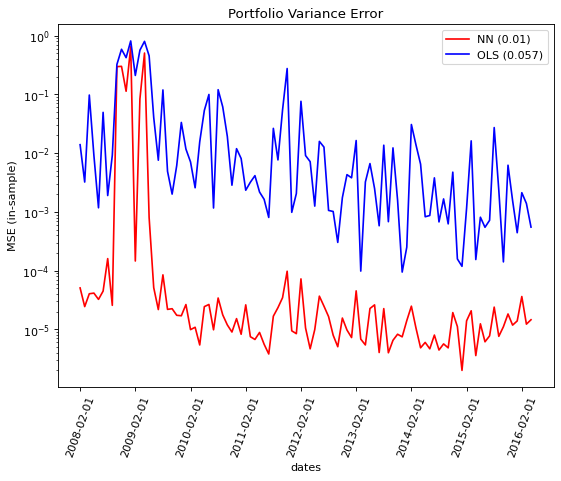

In [129]:
#Portfolio Variance MSE
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(MSE_NN,3)) +')'
plt.plot(MSE_array_NN_var_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(OLS_MSE_var,3)) +')'
plt.plot(MSE_array_OLS_var_in[:-1], color='blue', label=OLS_label)
plt.ylabel('MSE (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Variance Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


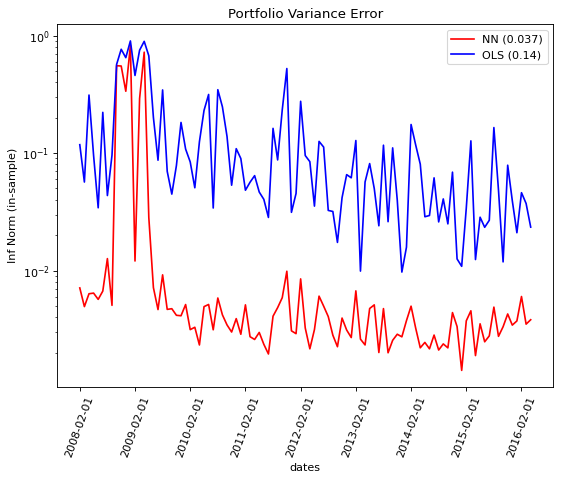

In [130]:
#Variance Inf Norm
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_var_inf_norm,3)) +')'
plt.plot(inf_norm_array_NN_var_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(OLS_var_inf_norm,3)) +')'
plt.plot(inf_norm_array_OLS_var_in[:-1], color='blue', label=OLS_label)
plt.ylabel('Inf Norm (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Variance Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


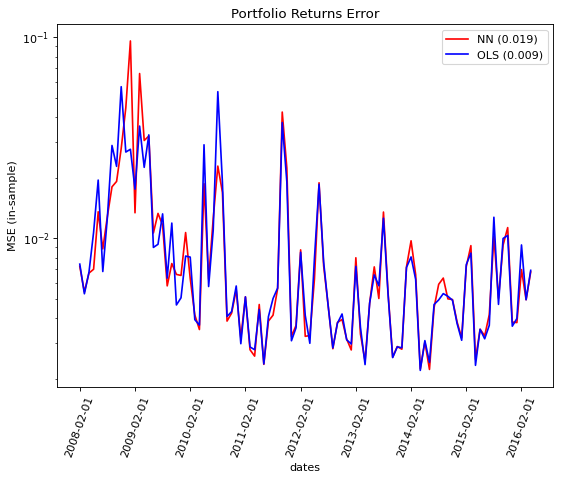

In [131]:
#Portfolio Returns MSE
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_MSE_var,3)) +')'
plt.plot(MSE_array_NN_y_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(MSE_linear,3)) +')'
plt.plot(MSE_array_OLS_y_in[:-1], color='blue', label=OLS_label)
plt.ylabel('MSE (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Returns Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


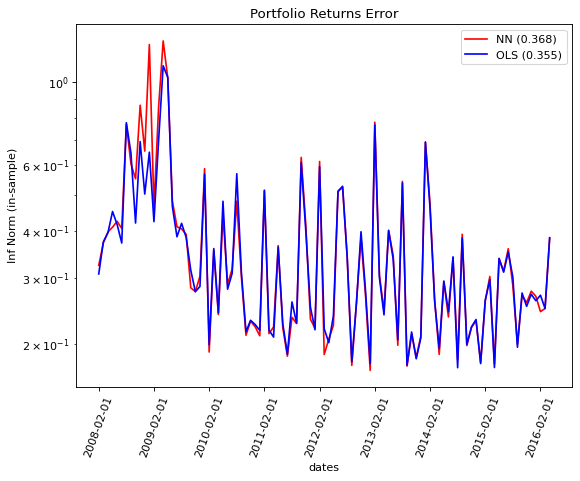

In [132]:
#Portfolio Returns Inf Norm
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(NN_y_hat_inf_norm,3)) +')'
plt.plot(inf_norm_array_NN_y_in[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(OLS_y_hat_inf_norm,3)) +')'
plt.plot(inf_norm_array_OLS_y_in[:-1], color='blue', label=OLS_label)
plt.ylabel('Inf Norm (in-sample)')
plt.xlabel('dates')
plt.title('Portfolio Returns Error')
#plt.xticks(np.arange(0,330,12), dates[np.arange(0,330,12)], rotation=70)
plt.xticks(np.arange(0,100,12), dates[np.arange(0,100,12)], rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")